In [9]:
import numpy as np
import matplotlib.pyplot as plt

# ----- make nice figures -----
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 200
from cycler import cycler
COLORS = ['#F00D2C', '#242482', '#0071BE', '#4E8F00', '#553C67', '#DA5319']
default_cycler = cycler(color=COLORS)
plt.rc('axes', prop_cycle=default_cycler) 
# -----------------------------

# Predicting Creep Rupture Stresses.

In a paper entitled "Theoretical design of ferritic creep resitant steels using neural network, kinetic and thermodynamic models," F. Brun, T. Yoshida et al. predicted creep rupture stresses for steel materials based on a set of 28 material properties. For details, see:

https://www.phase-trans.msm.cam.ac.uk/map/data/materials/creeprupt-b.html

We'll try to do the same thing with their data using Kernel Ridge Regression. The data is located in `data/creep_rupture_tests.txt`

In [4]:
data = np.loadtxt('data/creep_rupture_tests.txt')
print(data.shape)

# Check if we have missing data
np.any(np.isnan(data))

(2066, 31)


False

We will use the first 80% as training data, and then 80% of the remaining as validation data. The rest goes into testing data.

In [5]:
# shuffle rows
I_perm = np.random.permutation(len(data))
data = data[I_perm, :]

# Input variables
y = data[:, 1]
X = data[:, 2:30]

# training, validation and testing
num_train = int(0.8*len(X))
num_valid = int(0.2*0.8*len(X))

X_train = X[:num_train, :]
y_train = y[:num_train]

X_valid = X[num_train:(num_train + num_valid), :]
y_valid = y[num_train:(num_train + num_valid)]

X_test = X[(num_train + num_valid):, :]
y_test = y[(num_train + num_valid):]

We need to normalize our data since variable have different units. It's important to normalize each of the three training sets with **the same** normalization constants, which we estimate from the training data set. These constants are considered parameters to the model.

In [6]:
# Normalize data - the normalization constants are parameters
# of the model and must be estimated from the TRAINING data
mu_X = np.mean(X_train, axis = 0)
sig_X = np.std(X_train, axis = 0)
X_train_norm = (X_train - mu_X)/sig_X
X_valid_norm = (X_valid - mu_X)/sig_X
X_test_norm = (X_test - mu_X)/sig_X

We'll use Kernel Ridge Regression to map from the 28 inputs to the one output. It's in `scikit-learn` and is used like all other `scikit-learn` models. As parameters, we have to specify the regularization constant (here called `alpha` and the kernel type. Let's use the Guassian kernel (here called `rbf` for now). In reality, there is another parameter (`gamma`) which we could pass in if we're using the RBF kernel, but for now, we'll just use the default value.

Documentation:
https://scikit-learn.org/stable/modules/generated/sklearn.kernel_ridge.KernelRidge.html#sklearn.kernel_ridge.KernelRidge



In [7]:
# Kernel ridge regression -- No more design matrices!
from sklearn.kernel_ridge import KernelRidge

model = KernelRidge(alpha = 0.001, kernel = 'rbf')
model.fit(X_train_norm, y_train)

KernelRidge(alpha=0.001, coef0=1, degree=3, gamma=None, kernel='rbf',
            kernel_params=None)

Once trained, we'll try to predict the validation data to see how good our choices of the hyperparameters are.

Text(0.5, 1.0, 'Creep rupture stress prediction using KRR')

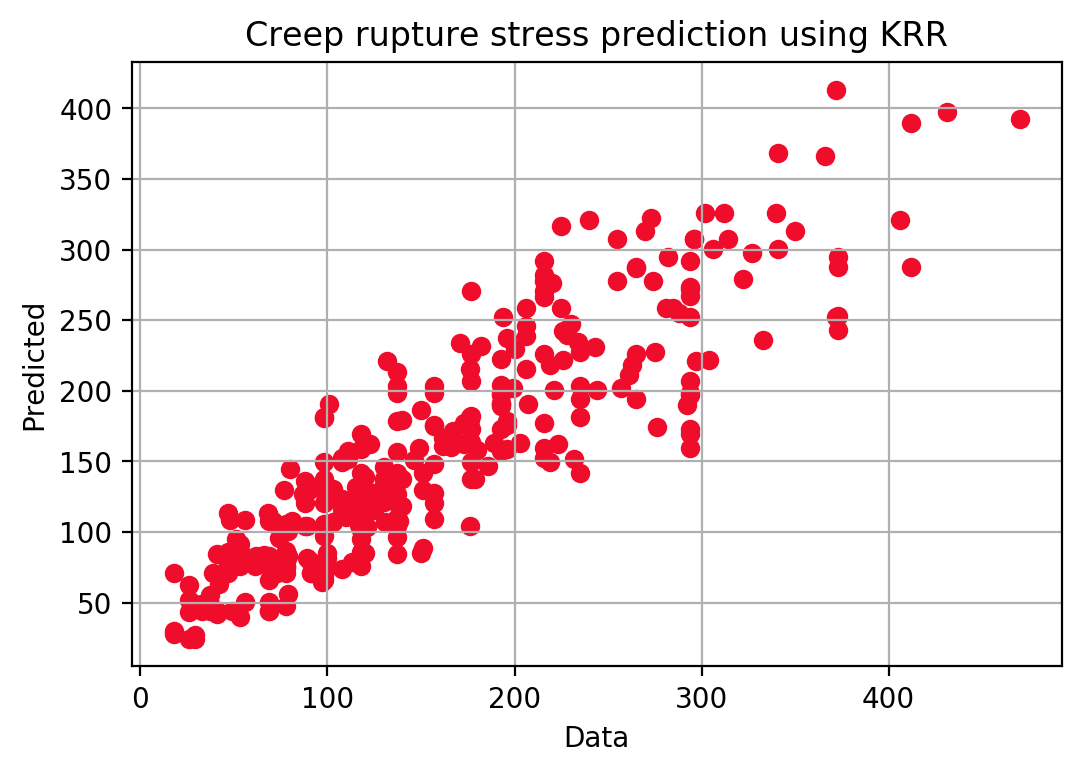

In [10]:
y_valid_model = model.predict(X_valid_norm)

# visualize results with a y-y plot
plt.scatter(y_valid, y_valid_model)
plt.grid()
plt.xlabel('Data')
plt.ylabel('Predicted')
plt.title('Creep rupture stress prediction using KRR')

`scikit-learn` regression metrics:

https://scikit-learn.org/stable/modules/model_evaluation.html#regression-metrics

In [11]:
from sklearn.metrics import mean_squared_error, r2_score

mse = mean_squared_error(y_valid, y_valid_model)
r2 = r2_score(y_valid, y_valid_model)

print("MSE = " + str(mse))
print("R2 = " + str(r2))

MSE = 1684.788963768545
R2 = 0.7960105716793286


In reality, we should try a large number of models, varying `alpha` and other parameters, and pick the best setting of these parameters according to how well they predict the validation set. Here, we'll vary `alpha`.

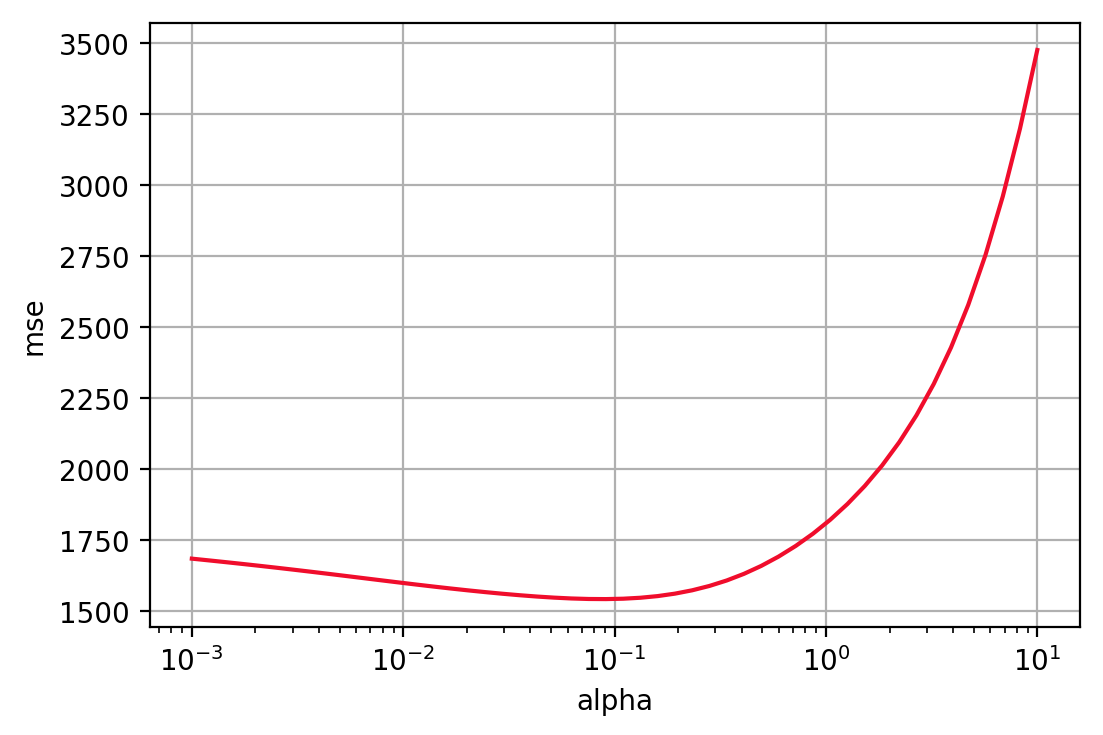

In [12]:
# lets try to pick a good alpha
alphas = np.logspace(-3, 1)
mses = np.zeros(len(alphas))

for i, alpha in enumerate(alphas):
    # Create an KRR model with specified alpha
    model = KernelRidge(alpha = alpha, kernel = 'rbf')
    model.fit(X_train_norm, y_train)
    y_valid_model = model.predict(X_valid_norm)
    
    # Save the mse for comparison later
    mses[i] = mean_squared_error(y_valid, y_valid_model)
    
plt.plot(alphas, mses)
plt.xscale('log')
plt.xlabel('alpha')
plt.ylabel('mse')
plt.grid()

In [13]:
# pick the best alpha
i_best = np.argmin(mses)
best_alpha = alphas[i_best]
best_mse = mses[i_best]
print("best_alpha = %f, best_mse = %f" %(best_alpha, best_mse))

best_alpha = 0.091030, best_mse = 1542.506070


Here's the best model.

MSE = 1542.5060696135586
R2 = 0.8132377774971806


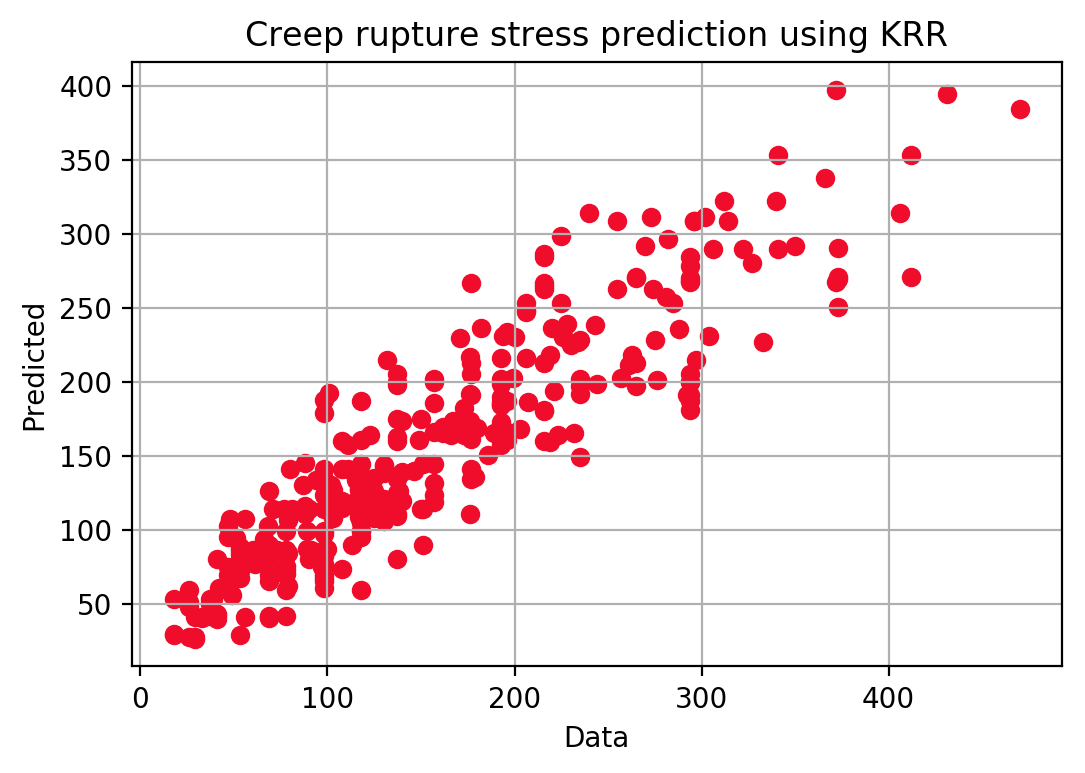

In [14]:
model = KernelRidge(alpha = best_alpha, kernel = 'rbf')
model.fit(X_train_norm, y_train)
y_valid_model = model.predict(X_valid_norm)

# visualize results with a y-y plot
plt.scatter(y_valid, y_valid_model)
plt.grid()
plt.xlabel('Data')
plt.ylabel('Predicted')
plt.title('Creep rupture stress prediction using KRR')

mse = mean_squared_error(y_valid, y_valid_model)
r2 = r2_score(y_valid, y_valid_model)
print("MSE = " + str(mse))
print("R2 = " + str(r2))

What about other kernels? Built in kernels can be found here:
    
    https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.pairwise_kernels.html

best_alpha = 3.237458, best_mse = 1538.385604


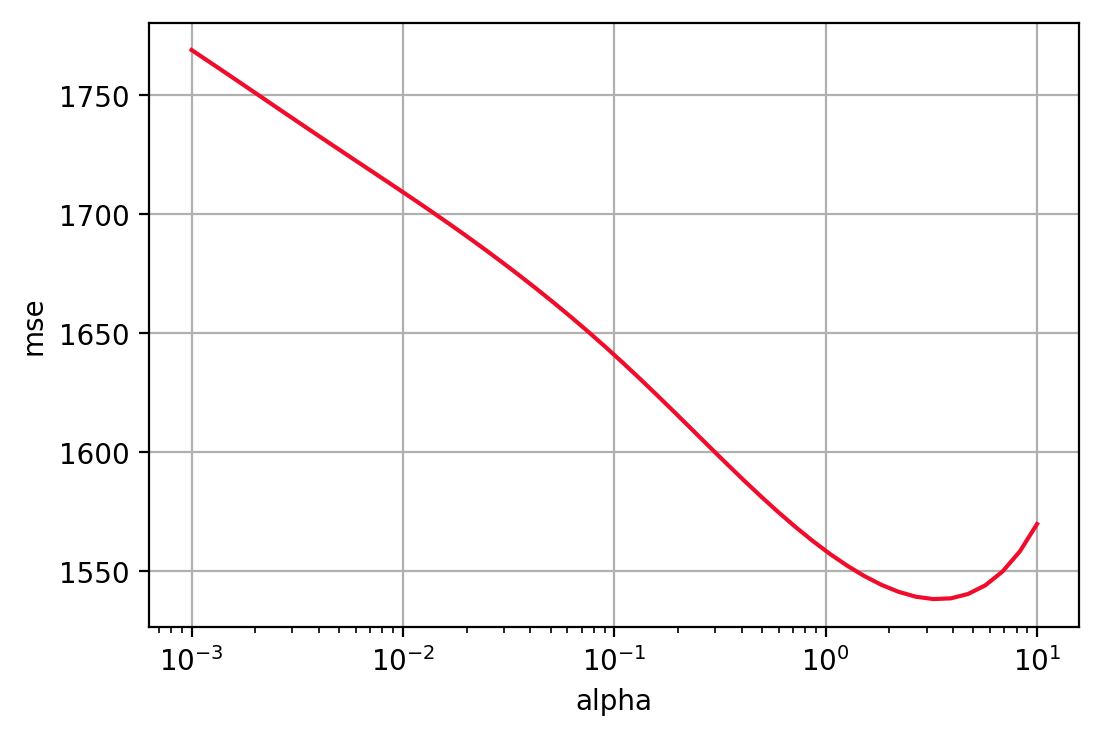

In [15]:
# What about other kernels?

for i, alpha in enumerate(alphas):
    # Create an KRR model with specified alpha
    model = KernelRidge(alpha = alpha, kernel = 'poly', degree = 5)
    model.fit(X_train_norm, y_train)
    y_valid_model = model.predict(X_valid_norm)
    
    # Save the mse for comparison later
    mses[i] = mean_squared_error(y_valid, y_valid_model)
    
plt.plot(alphas, mses)
plt.xscale('log')
plt.xlabel('alpha')
plt.ylabel('mse')
plt.grid()

# pick the best alpha
i_best = np.argmin(mses)
best_alpha = alphas[i_best]
best_mse = mses[i_best]
print("best_alpha = %f, best_mse = %f" %(best_alpha, best_mse))

Pick the best model, and apply to testing data

Estimated MSE for model: 1505.8884761970287


Text(0.5, 1.0, 'Creep rupture stress prediction using KRR')

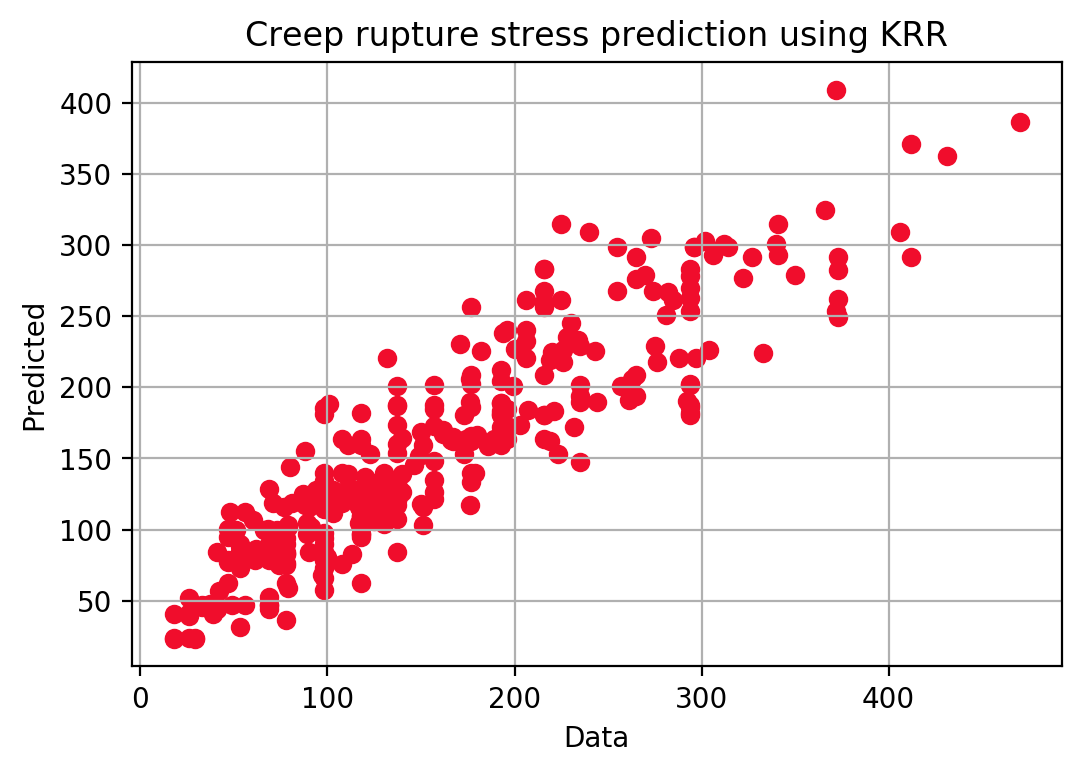

In [17]:
model = KernelRidge(alpha = 3.237458, kernel = 'poly', degree = 5)
model.fit(X_train_norm, y_train)
y_test_model = model.predict(X_test_norm)

mse_test = mean_squared_error(y_test, y_test_model)
print("Estimated MSE for model: " + str(mse_test))

plt.scatter(y_valid, y_valid_model)
plt.grid()
plt.xlabel('Data')
plt.ylabel('Predicted')
plt.title('Creep rupture stress prediction using KRR')

Mean residual = 2.387733
Median residual = 4.876186
Std residual = 38.732250


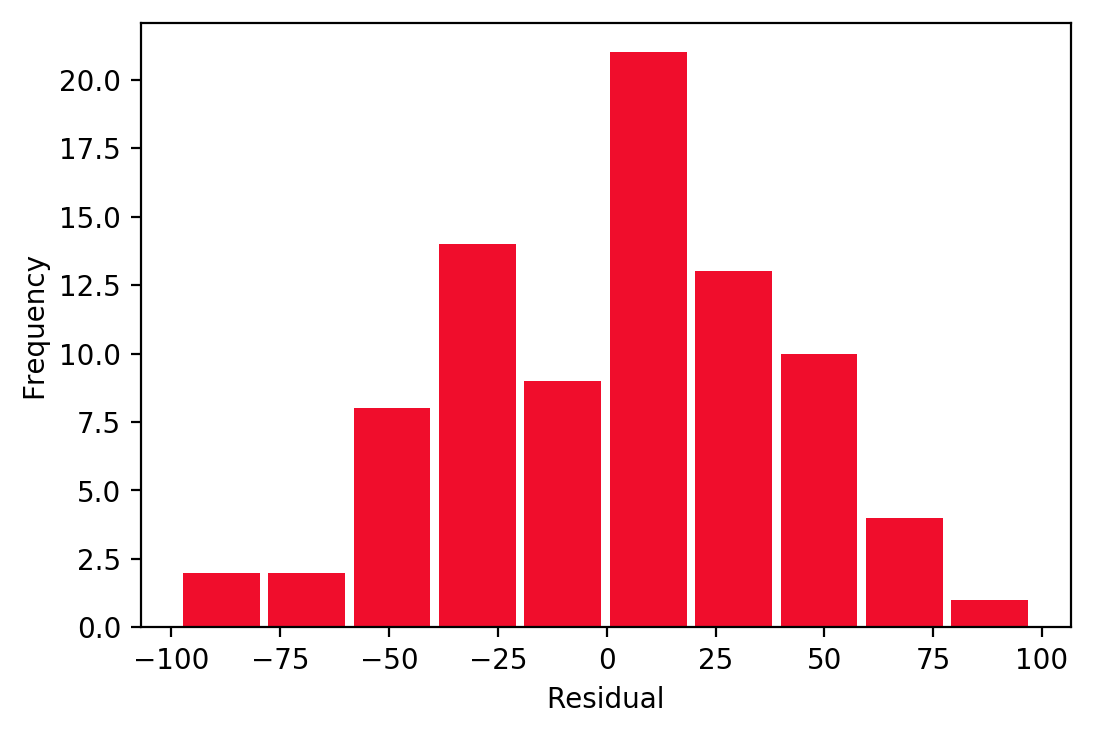

In [18]:
# Some basic residual analysis
r = y_test - y_test_model
plt.hist(r, rwidth= 0.9)
plt.xlabel('Residual')
plt.ylabel('Frequency')

print('Mean residual = %f' % np.mean(r))
print('Median residual = %f' % np.median(r))
print('Std residual = %f' % np.std(r))